# Sieci neuronowe i Deep Learning
# Temat 9: Konwolucyjne sieci neuronowe (cz. 2)

## Zadanie 9.1

Na podstawie wprowadzonego poniżej zbioru danych, zbudować model klasyfikacyjny (oparty o architekturę CNN), który będzie identyfikował, czy osoba przedstawiona na zdjęciu uśmiecha się, czy nie. Jakość zbudowanego rozwiązania zweryfikować na wskazanym zbiorze testowym.

In [100]:
import torch
import torch.nn as nn
import numpy as np

from IPython.display import Image



import matplotlib.pyplot as plt

**Klasyfikator identyfikujący uśmiech na zdjęciu twarzy** -
na podstawie zbioru danych CelebA (202 599 zdjęć twarzy znanych osób; dla każdego zdjęcia 40 cech, w tym indykator uśmiechu).

Zastosujemy technikę wzbogacenia danych (ang. **data augmentation**), a trening przeprowadzimy na podzbiorze 16 000 przykładów.

In [102]:
import torchvision 

image_path = 'E:\celeba'
celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=False)
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=False)
celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=False)

print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

Train set: 162770
Validation set: 19867
Test set: 19962


### Przekształcenia obrazów i augmentacja

Przykłady dostępnych technik augmentacji w 
modelu `torchvision.transforms` (przycinanie, odbicie, regulacja kontrastu, regulacja jasności, przybliżenie centralne):

In [103]:
# Funkcja, która wyodrębnia etykietę smile z listy 'attributes':
get_smile = lambda attr: attr[31]
from torchvision import transforms 
# Przykładowa funkcja do generowania przekształconych obrazów (augemntacja):
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

# Odpowiadające przekształcenie dla danych walidacyjnych i testowych (aby format był ten sam):
transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

Augmentacja (5 iteracji):

In [104]:
from torch.utils.data import DataLoader

celeba_train_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='train', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform_train,
                                                   target_transform=get_smile)

torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset, batch_size=2)


Formatowanie zbioru walidacyjnego i testowego:

In [105]:
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='valid', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform,
                                                   target_transform=get_smile)

celeba_test_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='test', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform,
                                                   target_transform=get_smile)



Wybieramy 16 000 przykładów treningowych i 1 000 przykładów walidacyjnych:

In [106]:
from torch.utils.data import Subset
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000)) 
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000)) 
 
print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))

Train set: 16000
Validation set: 1000


Tworzymy DataLoadery dla wszystkich trzech zbiorów:

In [107]:
batch_size = 64
from torch.utils.data import DataLoader
torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size, shuffle=False)

## Budowa modelu CNN

In [126]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())          
model.add_module('pool1', nn.AvgPool2d(kernel_size=3))   
model.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.AvgPool2d(kernel_size=5))
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2))
model.add_module('relu3', nn.ReLU())           
model.add_module('pool3', nn.AvgPool2d(kernel_size=5))


model.add_module('flatten', nn.Flatten()) 


model.add_module('fc1', nn.Linear(128, 64)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.50)) 

model.add_module('fc2', nn.Linear(64, 2)) 
model.add_module('softmax', nn.Softmax())

device = torch.device("cuda:0")

model = model.to(device) 

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=2, epochs=20)

In [206]:
class Block_Conv2d(nn.Module):
  def __init__(self , in_channels , out_channels , kernel_size , stride , padding):
    super(Block_Conv2d , self).__init__()
    self.conv = nn.Conv2d(in_channels , out_channels , kernel_size , stride , padding)
    self.activation = nn.ReLU()
  
  def forward(self , x):
    out = self.conv(x)
    out = self.activation(out)
    return out

In [207]:
class FirstBlock(nn.Module):
  def __init__(self):
    super(FirstBlock , self).__init__()

    self.conv1 = Block_Conv2d(3,16,3,2,0)
    self.conv2 = Block_Conv2d(16,16,3,1,0)
    self.conv3 = Block_Conv2d(16,64,3,1,1)
    self.maxPool = nn.AvgPool2d(kernel_size=(3,3) , stride=(2,2))

  def forward(self , x):

   out = self.conv1(x)
   out = self.conv2(out)
   out = self.maxPool(out)

      
   out = self.conv3(out)
   out = self.maxPool(out)
   
  
   return out

In [208]:
class ParallelBlock(nn.Module):
  def __init__(self , in_channels , nbr_kernels):
    super(ParallelBlock , self).__init__()

    self.branch1 = nn.Sequential(
        ConvolutionBlock(in_channels , 64 , 1 , 1 , 0),
        ConvolutionBlock(64 , 32 , 3 , 1 , 1),
        ConvolutionBlock(32 , 32 , 3 , 1 , 1)
        )

    self.branch2 = nn.Sequential(
        ConvolutionBlock(in_channels , 32 , 1 , 1 , 0),
        ConvolutionBlock(32 , 32 , 3 , 1 , 1)
        )

    self.branch3 = nn.Sequential(
        nn.AvgPool2d(kernel_size=(3,3) , stride=1 , padding=1),
        ConvolutionBlock(in_channels , 32 , 1 , 1 , 0)
        )

    self.branch4 = nn.Sequential(
        nn.AvgPool2d(kernel_size=(3,3) , stride=1 , padding=1),
        ConvolutionBlock(in_channels , 32 , 1 , 1 , 0),
        ConvolutionBlock(32 , 32 , 1 , 1 , 0)
        )

    self.branch5 = ConvolutionBlock(in_channels , 32 , 1 , 1 , 0)

  def forward(self , x):

    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)
    branch5 = self.branch5(x)

    out = torch.cat([branch1 , branch2 , branch3 , branch4, branch5] , 1)   

    return out   


In [209]:
class Model(nn.Module):
  def __init__(self):
    super(Model , self).__init__()

      
    self.FirstBlock = FirstBlock()
    self.Parallel = ParallelBlock(64 , 32)


    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc1 = nn.Linear(in_features=160 ,out_features= 300)
    self.fc2 = nn.Linear(in_features=300 , out_features= 2)
    self.flatten = nn.Flatten()
      

    
  def forward(self , x):
    
    out = self.FirstBlock(x)   
    out = self.Parallel(out) 
    out = self.avgpool(out)
    out = out.reshape(out.shape[0] , -1)

    out = self.flatten(out)
    out = self.fc1(out)
    out = nn.ReLU()(out)
    out = self.fc2(out)
    out = nn.Softmax()(out)

    return out

In [210]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [212]:
torch.manual_seed(1)

num_epochs = 50
model = Model()
model = model.to(device) 


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=0.01)


hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.5739 val_accuracy: 0.5870
Epoch 2 accuracy: 0.6329 val_accuracy: 0.7060
Epoch 3 accuracy: 0.7384 val_accuracy: 0.5840
Epoch 4 accuracy: 0.7722 val_accuracy: 0.7460
Epoch 5 accuracy: 0.7918 val_accuracy: 0.7440
Epoch 6 accuracy: 0.7990 val_accuracy: 0.7910
Epoch 7 accuracy: 0.8088 val_accuracy: 0.7960
Epoch 8 accuracy: 0.8171 val_accuracy: 0.8270
Epoch 9 accuracy: 0.8216 val_accuracy: 0.7960
Epoch 10 accuracy: 0.8258 val_accuracy: 0.8340
Epoch 11 accuracy: 0.8297 val_accuracy: 0.8490
Epoch 12 accuracy: 0.8314 val_accuracy: 0.7980
Epoch 13 accuracy: 0.8344 val_accuracy: 0.8500
Epoch 14 accuracy: 0.8396 val_accuracy: 0.8460
Epoch 15 accuracy: 0.8390 val_accuracy: 0.8210
Epoch 16 accuracy: 0.8294 val_accuracy: 0.8300
Epoch 17 accuracy: 0.8384 val_accuracy: 0.8530
Epoch 18 accuracy: 0.8436 val_accuracy: 0.8300
Epoch 19 accuracy: 0.8442 val_accuracy: 0.8360
Epoch 20 accuracy: 0.8479 val_accuracy: 0.8520
Epoch 21 accuracy: 0.8473 val_accuracy: 0.8540
Epoch 22 accuracy: 0.8

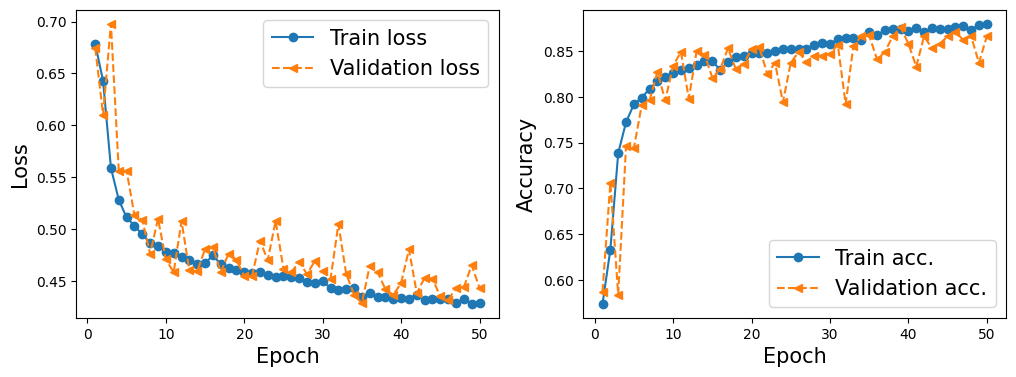

In [213]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

#### Dokładność na zbiorze walidacyjnym ciągle rośnie chociaż są znaczace odchylenia, kolejne 50 epok

In [214]:
num_epochs = 50
hist2 = train(model, num_epochs, train_dl, valid_dl)


Epoch 1 accuracy: 0.8799 val_accuracy: 0.8730
Epoch 2 accuracy: 0.8749 val_accuracy: 0.8560
Epoch 3 accuracy: 0.8831 val_accuracy: 0.8800
Epoch 4 accuracy: 0.8801 val_accuracy: 0.8770
Epoch 5 accuracy: 0.8821 val_accuracy: 0.8510
Epoch 6 accuracy: 0.8793 val_accuracy: 0.8640
Epoch 7 accuracy: 0.8767 val_accuracy: 0.8750
Epoch 8 accuracy: 0.8781 val_accuracy: 0.8730
Epoch 9 accuracy: 0.8826 val_accuracy: 0.8700
Epoch 10 accuracy: 0.8797 val_accuracy: 0.8860
Epoch 11 accuracy: 0.8814 val_accuracy: 0.8810
Epoch 12 accuracy: 0.8822 val_accuracy: 0.8690
Epoch 13 accuracy: 0.8816 val_accuracy: 0.8740
Epoch 14 accuracy: 0.8822 val_accuracy: 0.8650
Epoch 15 accuracy: 0.8817 val_accuracy: 0.8760
Epoch 16 accuracy: 0.8835 val_accuracy: 0.8730
Epoch 17 accuracy: 0.8823 val_accuracy: 0.8690
Epoch 18 accuracy: 0.8774 val_accuracy: 0.8760
Epoch 19 accuracy: 0.8848 val_accuracy: 0.8680
Epoch 20 accuracy: 0.8821 val_accuracy: 0.8790
Epoch 21 accuracy: 0.8830 val_accuracy: 0.8840
Epoch 22 accuracy: 0.8

### Dodkładność na poziomie prawie 90%, zbliżona do dokładności na zbiorze walidacyjnym. Potencjalnie przy wielokrotnie większej liczbie epok model wciąż mógłby się poprawiać

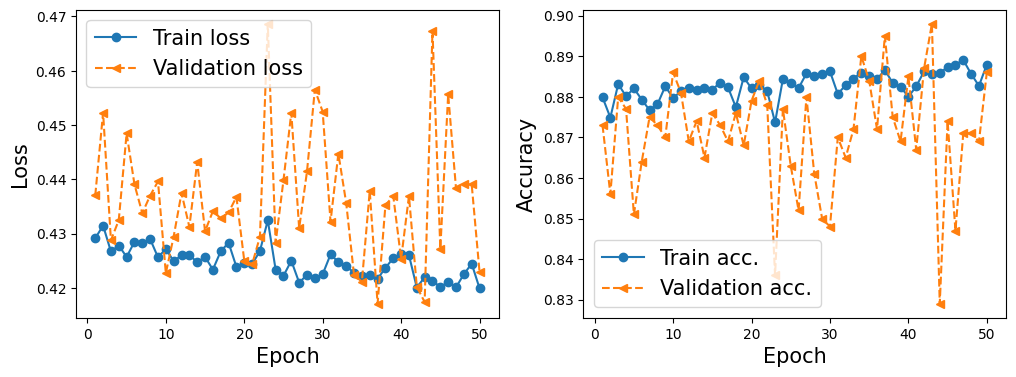

In [215]:
import matplotlib.pyplot as plt
import numpy as np

x_arr2 = np.arange(len(hist2[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr2, hist2[0], '-o', label='Train loss')
ax.plot(x_arr2, hist2[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr2, hist2[2], '-o', label='Train acc.')
ax.plot(x_arr2, hist2[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [ ]:
hist3 = train(model, num_epochs, train_dl, test_dl)